# Get data

In [1]:
from astropy.io import ascii

data = ascii.read('train.dat')

In [2]:
data = data.to_pandas()

In [3]:
data['classification'] = data[['quasar', 'galaxy', 'star']].idxmax(axis=1, skipna = True)

In [4]:
data

,SOURCE_ID,random_index,ra,dec,b,parallax,pm,phot_g_mean_mag,bp_g,g_rp,astrometric_chi2_al,astrometric_n_good_obs_al,phot_g_n_obs,phot_g_mean_flux_over_error,quasar,galaxy,star,classification
0,1265515347877933440,10075,222.274888,22.198161,62.881857,-0.336690,0.717317,17.933859,-2.318183,3.621396,2874.529297,557,540,134.341766,2.242062e-11,1.000000e+00,1.096192e-10,galaxy
1,5361196917262946432,15072,162.225588,-49.752394,8.437576,-0.036707,5.728018,19.842285,-2.758350,4.355935,163.854965,119,103,77.483009,9.393035e-12,9.991883e-01,8.117138e-04,galaxy
2,1232222032709253760,21887,214.149981,16.513552,67.616105,1.771744,2.912953,20.476004,-1.030676,2.346783,500.056610,211,261,91.175278,2.140544e-05,9.999388e-01,3.978026e-05,galaxy
3,1508859364417098624,48386,210.664719,46.206344,66.287072,-0.299802,0.610444,18.904287,-1.698452,2.988806,1701.720337,393,523,102.935295,6.760223e-08,9.999999e-01,2.498582e-08,galaxy
4,1253126291374182656,54587,215.173045,23.288794,69.478863,2.060775,1.578079,20.626930,-0.997219,2.439833,862.204041,228,230,67.853203,1.332725e-04,9.997067e-01,1.600439e-04,galaxy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,4044981546353011456,69520,278.208364,-32.878333,-10.773435,0.511303,9.041680,19.784698,0.835421,0.502546,189.521454,176,176,195.805237,2.756002e-10,3.725323e-10,1.000000e+00,star
149996,1821793980150487680,69522,300.758069,17.732733,-6.987042,0.630873,6.002502,20.828251,0.759409,0.383507,185.694946,132,139,87.892502,1.452123e-06,1.276155e-08,9.999985e-01,star
149997,5832556383888398592,69523,237.869691,-61.673765,-5.902291,0.319545,5.095318,19.579628,0.278986,1.041918,251.174911,273,308,259.207031,2.403798e-10,2.316001e-09,1.000000e+00,star
149998,4317359537494723456,69525,296.211251,13.973742,-5.125189,0.272538,4.946808,17.944607,0.400898,0.552906,377.758087,380,401,932.953857,2.086441e-14,1.383496e-12,1.000000e+00,star


/home/tinmai/anaconda3/envs/tin/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/tinmai/anaconda3/envs/tin/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


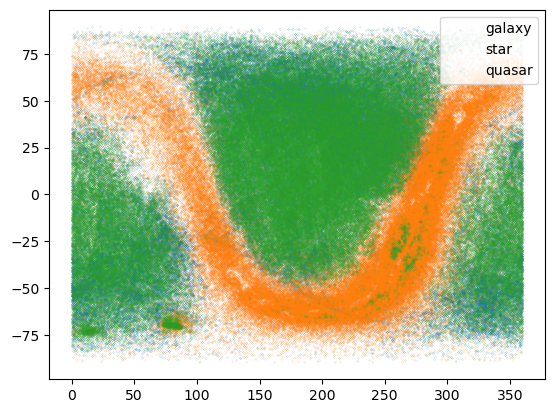

In [22]:
import matplotlib.pyplot as plt

for i in ['galaxy','star','quasar']:
    plt.scatter(data[data['classification'] == i]['ra'], data[data['classification'] == i]['dec'], s = 0.01, label = i)

plt.legend()

In [5]:
data['classification'].value_counts()

classification
galaxy    150000
quasar    150000
star      150000
Name: count, dtype: int64

In [5]:
import numpy as np

data['sinb'] = np.sin(np.deg2rad(data['b']))
data['uwe'] = np.sqrt(68.9230887591479data['astrometric_chi2_al']/(data['astrometric_n_good_obs_al'] - 5))
data['relvarg'] = np.sqrt(data['phot_g_n_obs'])/data['phot_g_mean_flux_over_error']

In [6]:
data['relvarg'].isna().sum()

0

# Gaussian Mixture Model

In [1]:
from astropy.io import ascii
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_dataframe(filename):
    data = ascii.read(filename)
    data = data.to_pandas()
    
    data['sinb'] = np.sin(np.deg2rad(data['b']))
    data['uwe'] = np.sqrt(data['astrometric_chi2_al']/(data['astrometric_n_good_obs_al'] - 5))
    data['relvarg'] = np.sqrt(data['phot_g_n_obs'])/data['phot_g_mean_flux_over_error']
    
    data['classification'] = data[['star', 'quasar', 'galaxy']].idxmax(axis=1, skipna = True)

    return data

train = make_dataframe('train.dat')
test = make_dataframe('test.dat')

In [2]:
from sklearn.utils import shuffle

train = shuffle(train, random_state=42)
test = shuffle(test, random_state=42)

feature_names = np.array(['sinb','uwe','parallax','pm','phot_g_mean_mag','bp_g','g_rp','relvarg'])
X_train = train[feature_names]
y_train = train['classification']
X_test = test[feature_names]
y_test = test['classification']

In [3]:
X_train, y_train

(            sinb       uwe  parallax         pm  phot_g_mean_mag      bp_g  \
 59770   0.656816  1.008375 -0.016108   0.325646        18.595152  0.059502   
 21362   0.933771  1.698997  0.378388   0.828699        20.096067 -0.489084   
 127324 -0.474581  1.036373  0.353182  10.346584        18.754663  0.432184   
 140509 -0.050280  1.120445  1.150618   5.516022        20.633396  1.110018   
 144297  0.446134  1.022912  0.465828  11.350672        16.283392  0.332817   
 ...          ...       ...       ...        ...              ...       ...   
 119879  0.546096  1.022696  2.595791  30.584883        18.577711  1.665348   
 103694 -0.086390  1.066885  0.308557   5.023288        17.722292  0.577185   
 131932  0.222425  1.031807  1.441614   3.613896        18.767248  1.609241   
 146867 -0.852325  1.044032  1.839144  19.949551        20.413462  0.929621   
 121958  0.104013  1.033632  0.621881  11.455461        16.116234  0.485411   
 
             g_rp   relvarg  
 59770   0.265587  0

In [4]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)

X_test=StandardScaler().fit(X_test).transform(X_test)

# feature_names = scaler.feature_names_in_

In [5]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

# Split data into training and test sets
# X_train_val, X_test, y_train_val, y_test = train_test_split(scaled_features, label, test_size=0.5, random_state=42)

# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.5, random_state=42)


In [6]:
# X_train_val.shape, X_train.shape, X_val.shape

In [7]:
y_train.value_counts()

classification
quasar    50000
galaxy    50000
star      50000
Name: count, dtype: int64

In [8]:
from GMMClassifier import GMMClassifier

# gmm = GMMClassifier(n_components=18, covariance_type='full', random_state=42)
# gmm.fit(X_train, y_train)
# y_prob = gmm.predict_proba(X_val)

In [11]:
from sklearn.utils.estimator_checks import check_estimator

# check_estimator(GMMClassifier()) 

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = GMMClassifier(random_state=42)
param = {'n_components': np.arange(2,35),
    'covariance_type': ['full', 'tied', 'diag', 'spherical'], 
    'prob_scale':np.arange(1,5)}
search = GridSearchCV(clf, param, scoring = 'neg_log_loss', cv=3, n_jobs=8)
search.fit(X_train, y_train)

In [17]:
search.best_estimator_

GMMClassifier(n_components=33, prob_scale=1, random_state=42)

[Text(0.5, 0, 'Number of components'),
 Text(0, 0.5, 'Cross entropy loss'),
 Text(0.5, 1.0, 'Validation Curve for GMMClassifier')]

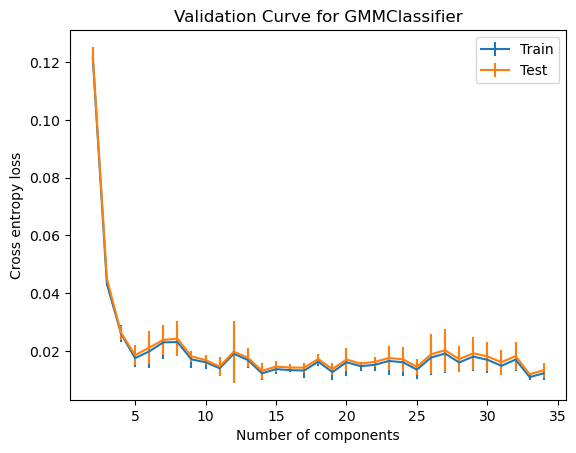

In [21]:
from sklearn.model_selection import ValidationCurveDisplay

# Define the range for n_components
n_comp = np.arange(2, 35)

disp = ValidationCurveDisplay.from_estimator(
    GMMClassifier(covariance_type='full', prob_scale = 3, random_state=42),
    X_train,  # your training features
    y_train,  # your training labels
    param_name="n_components",
    param_range=n_comp,
    cv=3,
    scoring='neg_log_loss',
    negate_score=True,
    std_display_style="errorbar",
    n_jobs=8,
)
disp.ax_.set(
    xlabel="Number of components",
    ylabel="Cross entropy loss",
    title="Validation Curve for GMMClassifier",
)


/home/tinmai/Desktop/Machine learning/GAIA/GMMClassifier.py:56: RuntimeWarning: invalid value encountered in divide
  probs_norm = probs/probs_sum
/home/tinmai/anaconda3/envs/tin/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/tinmai/anaconda3/envs/tin/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/tinmai/anaconda3/envs/tin/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/tinmai/anaconda3/envs/tin/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File 

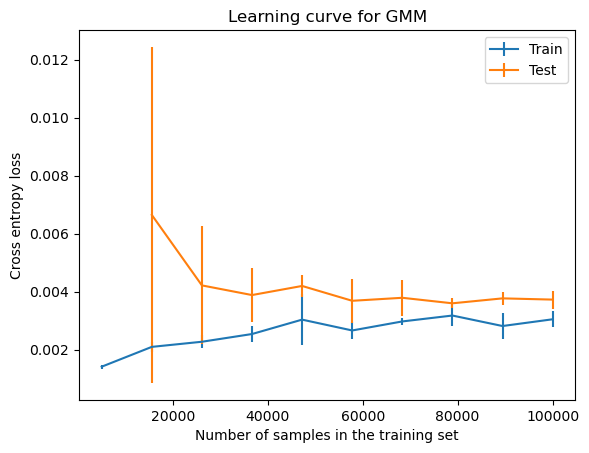

In [19]:
from sklearn.model_selection import LearningCurveDisplay

display = LearningCurveDisplay.from_estimator(
    GMMClassifier(n_components = 14, covariance_type='full', prob_scale = 3, random_state=42),
    X_train,
    y_train,
    train_sizes=np.linspace(0.05,1,num = 10),
    cv=3,
    scoring = 'neg_log_loss',
    negate_score=True,  # to use when metric starts with "neg_"
    score_name = 'Cross entropy loss',
    std_display_style="errorbar",
    n_jobs=4,
)
_ = display.ax_.set(title="Learning curve for GMM")

In [22]:
from sklearn.model_selection import cross_val_score

classifier = GMMClassifier(n_components=14, covariance_type='full', prob_scale = 3, random_state=42)
val_score = cross_val_score(classifier, X_train, y_train, cv=3, n_jobs=4)
print(
    "The mean score using cross-validation is: "
    f"{val_score.mean():.5f} ± {val_score.std():.5f}"
)

The mean score using cross-validation is: 0.99963 ± 0.00008


In [9]:
classifier = GMMClassifier(n_components=14, covariance_type='full', prob_scale = 3, random_state=42)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)


In [28]:
y_test

234806    quasar
41549     galaxy
169822    quasar
313751      star
32640     galaxy
           ...  
259178    quasar
365838      star
131932    galaxy
146867    galaxy
121958    galaxy
Name: classification, Length: 450000, dtype: object

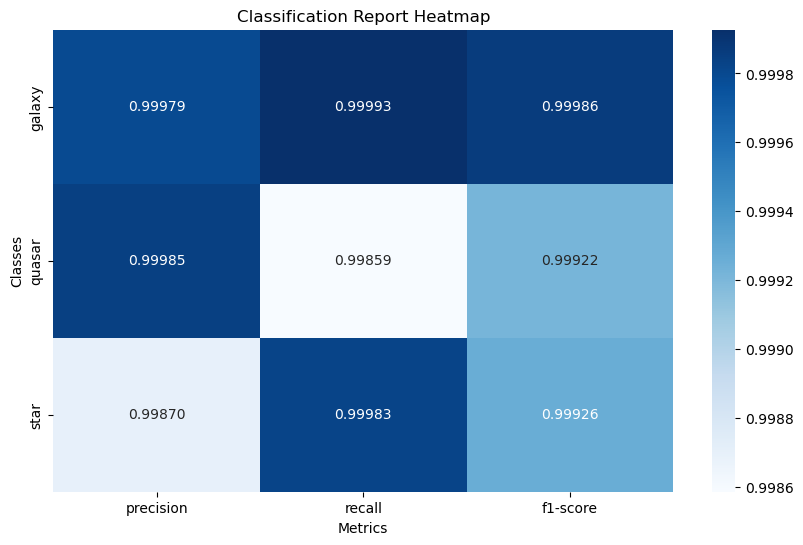

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the classification report as a dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()
# Convert the dictionary to a Pandas DataFrame for easier plotting
report_df = report_df.drop(labels=["accuracy", "macro avg", "weighted avg"], errors="ignore")

plt.figure(figsize=(10, 6))
sns.heatmap(report_df[['precision','recall','f1-score']], annot=True, cmap="Blues", fmt=".5f")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.title("Classification Report Heatmap")
plt.show()

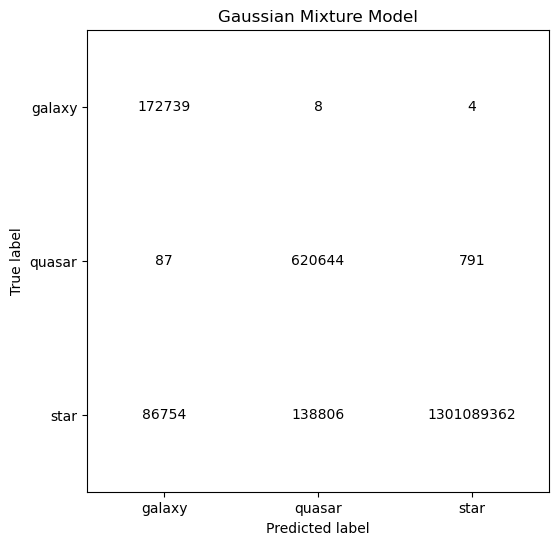

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
from plot_confusion import plot_confusion

labels = classifier.classes_

plot_confusion(y_test,y_pred, labels = labels, title = 'Gaussian Mixture Model', savefig = True, corrected  = True)


In [21]:
classifier.classes_

array(['galaxy', 'quasar', 'star'], dtype='<U6')

In [14]:
# import matplotlib as mpl
# # constant_cmap = mpl.colors.ListedColormap(["white"])

# cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)

# labels = classifier.classes_
# count = {'star':1301314924, 'quasar': 621523, 'galaxy':172752}

# for i, cl in enumerate(labels):
#     cm[i,:] = cm[i,:]*(count[cl]/np.sum(cm[i,:]))
#     print(cm[i,:])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=labels
#                              )

# fig, ax = plt.subplots(figsize=(8, 6))
# disp.plot(values_format="d", colorbar = False, ax=ax)

# if ax.images:
#     ax.images[0].set_visible(False)
# for txt in disp.ax_.texts:
#     txt.set_color("black")

# ax.set_title('GMM')


# Feature selection

In [91]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [95]:
from sklearn.pipeline import make_pipeline

model_without_selection = GMMClassifier(n_components=18, covariance_type='full', random_state=42)
model_with_selection = make_pipeline(
    SelectKBest(score_func=f_classif, k=2),
    GMMClassifier(n_components=18, covariance_type='full', random_state=42)
)

In [97]:
from sklearn.model_selection import cross_validate

cv_results_without_selection = cross_validate(
    model_without_selection, X_train, y_train, cv = 3
)
cv_results_without_selection = pd.DataFrame(cv_results_without_selection)


In [99]:
cv_results_with_selection = cross_validate(
    model_with_selection, X_train, y_train, return_estimator=True, cv = 3
)
cv_results_with_selection = pd.DataFrame(cv_results_with_selection)

In [100]:
cv_results = pd.concat(
    [cv_results_without_selection, cv_results_with_selection],
    axis=1,
    keys=["Without feature selection", "With feature selection"],
)
# swap the level of the multi-index of the columns
cv_results = cv_results.swaplevel(axis="columns")

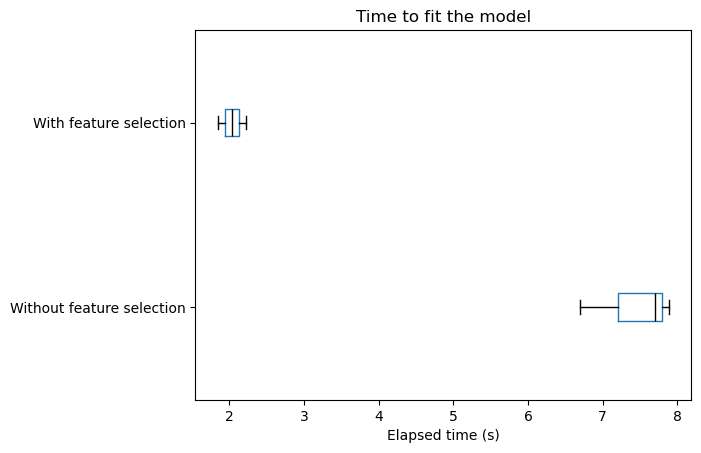

In [101]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
cv_results["fit_time"].plot.box(color=color, vert=False)
plt.xlabel("Elapsed time (s)")
_ = plt.title("Time to fit the model")

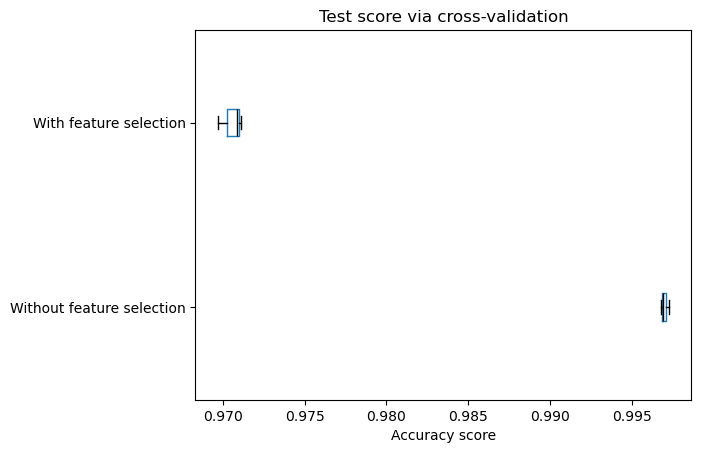

In [102]:
cv_results["test_score"].plot.box(color=color, vert=False)
plt.xlabel("Accuracy score")
_ = plt.title("Test score via cross-validation")

# Features importance

In [23]:
from sklearn.inspection import permutation_importance

def plot_feature_importances(perm_importance_result, feat_name, savefig = True):
    """bar plot the feature importance"""

    fig, ax = plt.subplots(figsize = (8,7))

    indices = perm_importance_result["importances_mean"].argsort()
    plt.barh(
        range(len(indices)),
        perm_importance_result["importances_mean"][indices],
        xerr=perm_importance_result["importances_std"][indices],
    )

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])
    ax.set_title("Gaussian Mixture Model")
    ax.tick_params(axis='both', which='major', labelsize=12)
    # ax.set_yticks(fontsize=12)
    # ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()

    plt.savefig('GMM_importance.png')


In [ ]:
model = GMMClassifier(n_components=14, covariance_type='full', prob_scale = 3, random_state=42)
model.fit(X_train, y_train)

perm_importance_result_train = permutation_importance(
    model, X_train, y_train, n_repeats=20, random_state=42
)

plot_feature_importances(perm_importance_result_train, feature_names)

# ROC

In [20]:
from sklearn.preprocessing import LabelBinarizer

model = GMMClassifier(n_components=18, covariance_type='full', prob_scale = 3, random_state=42)

y_score = model.fit(X_train, y_train).predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

NameError: name 'label_binarize' is not defined

In [11]:
from sklearn.metrics import auc, roc_curve

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.5f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.99998


In [17]:
from sklearn.metrics import RocCurveDisplay

n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.5f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.99968


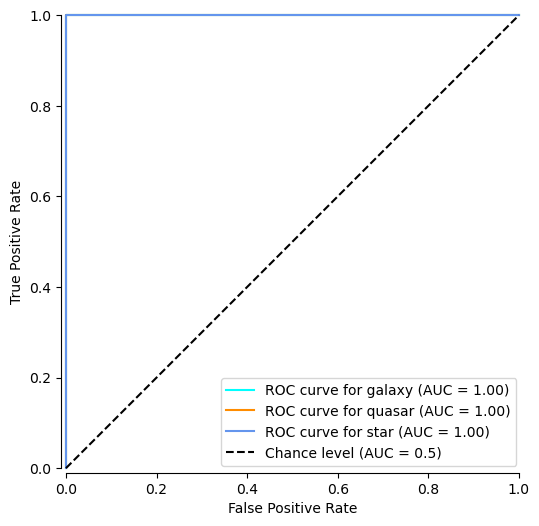

In [19]:
from itertools import cycle


target_names = model.classes_
fig, ax = plt.subplots(figsize=(6, 6))

# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.5f})",
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

# plt.plot(
#     fpr["macro"],
#     tpr["macro"],
#     label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.5f})",
#     color="navy",
#     linestyle=":",
#     linewidth=4,
# )

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
        despine=True,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    # title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

# Precision - Recall

In [21]:
from sklearn.metrics import average_precision_score, precision_recall_curve

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_onehot_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_onehot_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_onehot_test, y_score, average="micro")

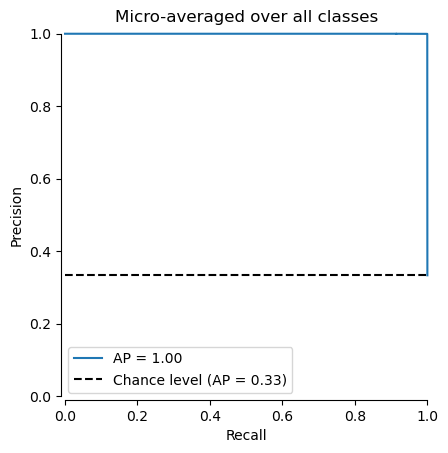

In [25]:
from collections import Counter
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
    prevalence_pos_label=Counter(y_onehot_test.ravel())[1] / y_onehot_test.size,
)
display.plot(plot_chance_level=True, despine=True)
_ = display.ax_.set_title("Micro-averaged over all classes")

In [3]:
from GMMClassifier import best_GMM, GaussianMixture

In [4]:
best_GMM()

GMMClassifier(n_components=14, prob_scale=3, random_state=42)